# 6.8300 Problem Set 2

This homework will cover

- How to steer a sine wave
- How to derive the 2D Fourier Transform from first principles
- How to properly compute image derivatives
- How to orient convolutions in any direction with [steerable filters]( https://people.csail.mit.edu/billf/publications/Design_and_Use_of_Steerable_Filters.pdf )

It will be graded mostly on an autograder with some manual review of images!

## Part 0: Imports + Helpers
- Please pip install any of the libraries if you are missing anything (having the most recent imports should work!).
- Please feel free to use these implemented functions anywhere in the notebook. Note some of these functions may use functions that you need to properly implement to use correctly.

In [1]:
!pip install scikit-image

In [2]:
from jaxtyping import Float, Complex
from torch import Tensor
from typing import Tuple, Callable
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import torch
from IPython.display import HTML
import torch.nn.functional as F
from skimage.color import rgb2gray
from skimage.data import astronaut as _astronaut
from skimage.data import hubble_deep_field
from skimage.util import img_as_float
from scipy.ndimage import gaussian_filter as gaussian_filter_scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math

In [3]:
def return_animation():
    """
    Return an animation of a sine wave being steered 
    by changing the coefficients a and b.
    """
    x = torch.linspace(0, 2 * np.pi, 200)
    x_np = x.numpy()
    fig, ax = plt.subplots(figsize=(6, 4))
    (line_a,) = ax.plot(x_np, np.zeros_like(x_np), label=r"$a\cos(x)$", color="C0")
    (line_b,) = ax.plot(x_np, np.zeros_like(x_np), label=r"$b\sin(x)$", color="C1")
    (line_sum,) = ax.plot(
        x_np, np.zeros_like(x_np), label=r"$a\cos(x)+b\sin(x)$", color="C2", linewidth=2
    )
    ax.set_xlim(0, 2 * np.pi)
    ax.set_ylim(-1.5, 1.5)
    ax.legend(loc="upper right")
    angles = np.linspace(0, 2 * np.pi, 60)

    def update(frame):
        angle = angles[frame]
        a, b = angle_to_coeffs(torch.tensor(angle))

        y_a = a * torch.cos(x)
        y_b = b * torch.sin(x)
        y_sum = coeffs_to_sine(a, b, x)

        line_a.set_ydata(y_a.numpy())
        line_b.set_ydata(y_b.numpy())
        line_sum.set_ydata(y_sum.numpy())

        ax.set_title(f"Sine Steering (a = {a:.2f}, b = {b:.2f})")
        return line_a, line_b, line_sum

    ani = animation.FuncAnimation(
        fig, update, frames=len(angles), interval=100, blit=True
    )
    return ani

In [4]:
def gaussian_filter(
    img: torch.Tensor,  # The input tensor
    sigma: float,  # Standard deviation for the Gaussian kernel
    order: int | list = 0,  # The order of the filter's derivative along each dim
    mode: str = "reflect",  # Padding mode for `torch.nn.functional.pad`
    truncate: float = 4.0,  # Number of standard deviations to sample the filter
) -> torch.Tensor:
    """
    Convolves an image with a Gaussian kernel (or its derivatives).
    """

    # Specify the dimensions of the convolution to use
    ndim = img.ndim - 2
    if isinstance(order, int):
        order = [order] * ndim
    else:
        assert len(order) == ndim, "Specify the Gaussian derivative order for each dim"
    convfn = getattr(F, f"conv{ndim}d")

    # Convolve along the rows, columns, and depth (optional)
    for dim, derivative_order in enumerate(order):
        img = _conv(img, convfn, sigma, derivative_order, truncate, mode, dim)
    return img


def _conv(
    img: torch.Tensor,
    convfn: Callable,
    sigma: float,
    order: int,
    truncate: float,
    mode: str,
    dim: int,
):
    # Make a 1D kernel and pad such that the image size remains the same
    kernel = _gaussian_filter_1d(sigma, order, truncate, img.dtype, img.device)
    padding = len(kernel) // 2

    # Specify the padding dimensions
    pad = [0] * 2 * (img.ndim - 2)
    for idx in range(2 * dim, 2 * dim + 2):
        pad[idx] = padding
    pad = pad[::-1]
    x = F.pad(img, pad, mode=mode)

    # Specify the dimension along which to do the convolution
    view = [1] * img.ndim
    view[dim + 2] *= -1

    return convfn(x, weight=kernel.view(*view))


def astronaut(dtype: torch.dtype = torch.float32):
    img = _astronaut()
    img = img_as_float(img)
    img = rgb2gray(img)
    img = torch.from_numpy(img).to(dtype)
    return img[None, None]


def hubble(dtype: torch.dtype = torch.float32):
    img = hubble_deep_field()[0:500, 0:500]
    img = img_as_float(img)
    img = rgb2gray(img)
    img = torch.from_numpy(img).to(dtype)
    return img[None, None]


def imshow(*imgs):
    imgs = [img.squeeze().detach().cpu() for img in imgs]
    n_imgs = len(imgs)
    fig, axs = plt.subplots(ncols=n_imgs, figsize=(n_imgs * 2 + 2, 3))
    for ax, img in zip(axs, imgs):
        ax.imshow(img, cmap="gray")
        ax.axis("off")
    plt.tight_layout()
    return fig, axs


## Part 1: Steerable Bases
> Steerable bases refer to a set of basis functions that can be linearly combined to produce a function in the same family, oriented (or phased) in any direction.

In this part, we consider the simplest case: 1D sinusoids. We will see that a sine and cosine of the same frequency form a steerable basis for sinusoids. Any linear combination of a sine and a cosine (of the same frequency) is just another sine wave of that same frequency, with a different phase shift. In other words, by adjusting the coefficients in front of sin(x) and cos(x), we are “steering” the phase of the resulting sine wave without changing its frequency.

### Part 1.1 Sine + Cosine = Sine

**(a)** Let’s derive the central identity for sine steering.  
Given the basis functions $\sin(x)$ and $\cos(x)$, show algebraically that the linear combination $a\cos(x) + b\sin(x)$ is a sinusoid of the same frequency.

In other words, solve for $R$ and $\theta$ such that

$$
y(x) = a\cos(x) + b\sin(x) = R\sin(x + \theta).
$$
Hint: $\sin(a+b) = \sin(a)\cos(b) + \cos(a)\sin(b).$


With these results, complete the following function:


In [5]:
def identity(
    a: Float[Tensor, "..."], b: Float[Tensor, "..."]
) -> tuple[Float[Tensor, "..."], Float[Tensor, "..."]]:
    """ 
    Compute and return the amplitude and phase shift for the problem.
    """
    # STUDENT CODE HERE
    R = torch.sqrt(a**2 + b**2)
    theta = torch.atan2(a, b)
    # END STUDENT CODE
    return R, theta


### Part 1.2 Steer a sine!
Now that we can rewrite our functions in terms of a single sine, we can control its amplitude and phase using the coefficients a and b. 


(a) Complete the function coeffs_to_sine such that, given the coefficients a and b, it returns the sine from Part 1.1.

In [6]:
def coeffs_to_sine(
    a: Float[Tensor, "..."], b: Float[Tensor, "..."], x: Float[Tensor, "..."]
) -> Float[Tensor, "..."]:
    """
    Computes a linear combination of cosine and sine functions given coefficients a and b.

    The function returns the value a*cos(x) + b*sin(x) for each element in x.

    Args:
        a: Coefficient for the cosine term.
        b: Coefficient for the sine term.
        x: Tensor of angles.

    Returns:
        A tensor of the same shape as x representing a*cos(x) + b*sin(x).
    """
    # STUDENT CODE HERE
    y = a * torch.cos(x) + b * torch.sin(x)
    # END STUDENT CODE
    return y


(b) Complete the function angle_to_coeffs such that, given an angle (in radians), it returns the a and b coefficients in the unit circle.

In [7]:
def angle_to_coeffs(
    angle: Float[Tensor, "..."],
) -> Tuple[Float[Tensor, "..."], Float[Tensor, "..."]]:
    """
    Converts an angle to its corresponding cosine and sine coefficients.

    This function computes the cosine and sine of the provided angle, effectively mapping the angle
    to a point on the unit circle.

    Args:
        angle: Tensor of angles.

    Returns:
        A tuple (cos(angle), sin(angle)) of tensors, each with the same shape as the input.
    """
    # STUDENT CODE HERE
    cos_angle = torch.cos(angle)
    sin_angle = torch.sin(angle)
    # END STUDENT CODE
    return cos_angle, sin_angle


(c) Run the cell below to show how the sine is steered by varying our coefficients! Confirm your code works by comparing the output to /outputs/1.2 (same for rest of images produced!)

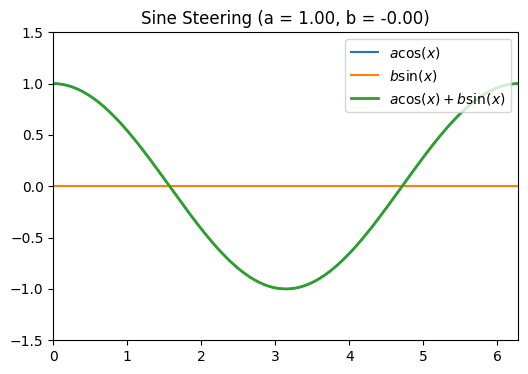

In [8]:
ani = return_animation()
HTML(ani.to_jshtml())

## Part 2: The Fourier Transform
> How does the Fourier Transform arise naturally from our image processing toolkit?

Note: Some of the graphics in this section are taken from this [blog post](https://medium.com/data-science/deriving-convolution-from-first-principles-4ff124888028).

In Lecture 3, we discussed how images can be viewed as functions in an inner product space. As such, they can be represented as a linear combination of basis functions that span our image space. We saw two different bases:
- The pixel basis, where each basis function is the image with a single pixel set to 1 and all others to 0.
- The (real) Fourier basis, where each basis function is a sine or cosine wave of a certain frequency.

The upshot of being able to represent images in these bases is that different linear operators lend themselves to being more interpretable / easier to compute in different bases. In fact, in Lecture 4 we saw that we can derive the Fourier Transform as precisely the change of basis in the inner product space where operators that preserve translational symmetry in the image space are diagonalized.

An example of such an operator is the blurring convolution, as seen below:

<img src="img/blur_shift.png" width="50%">

So, intuitively, the Fourier basis is precisely the basis in which this blur (and the other shift-commutative operators) is easy to compute and interpret!

If you have encountered the Fourier Transform before (e.g., in a traditional signals course), the above characterization might not be immediately obvious, so let's take a look at how we arrive at this.

### Part 2.1: Torus Shifts

When applying our image processing operations on 2D images, we assume circular boundaries. For instance, when we shift an image horizontally or vertically, we expect the pixels that are "pushed outside the borders" to loop back around to the other side of the image.

Effectively, we are "glueing" the horizontal and vertical edges of the image together. Topologically, this corresponds to constructing a torus $T^2 = S^1 \times S^1$, as seen below:

![](img/torus_construction.gif)

We also saw in Lecture how shifts applied as linear operators on a 1D signal with $n$ discrete entries take the form of a $n \times n$ permutation matrix that looks like a shifted identity:

<img src="img/1D_shift.png" width="60%">

With these facts, implement the function shift_operator, which extends this idea to 2D images. This function takes an image shape $(h, w)$ and how many pixels it should be shifted horizontally/vertically, and returns the linear operator corresponding to the shift that operates on a flattened image with circular boundary conditions (that is, a $hw \times hw$ matrix).

In [9]:
def shift_operator(img_shape: Tuple[int, int], shift_x: int, shift_y: int) -> Tensor:
    """
    Constructs a 2D shift operator for an image with circular boundaries.

    Args:
        img_shape: Tuple[int, int]
            The (height, width) dimensions of the image.
        shift_x: int
            The number of pixels to shift horizontally.
        shift_y: int
            The number of pixels to shift vertically.

    Returns:
        Tensor of shape (h*w, h*w)
            A matrix that, when applied to a flattened image, shifts it by the specified amounts.
    """
    # STUDENT CODE HERE
    h, w = img_shape

    Sx = torch.zeros((w, w), dtype=torch.float32)
    x = torch.arange(w)
    Sx[x, (x + shift_x) % w] = 1.0

    Sy = torch.zeros((h, h), dtype=torch.float32)
    y = torch.arange(h)
    Sy[y, (y + shift_y) % h] = 1.0

    shift_matrix = torch.kron(Sy, Sx)
    # END STUDENT CODE
    return shift_matrix



See /outputs/2.1 for what the below function should look like (same for rest of notebook).

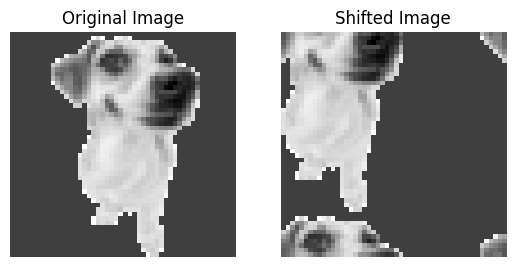

In [10]:
img = torch.tensor(plt.imread("img/dog.png"))[..., 0]

S = shift_operator(img.shape, shift_x=15, shift_y=10)  # Experiment with these values!
shifted_img = (S @ img.flatten()).reshape(img.shape)

# Visualize the original and shifted images
plt.subplot(121)
plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(122)
plt.imshow(shifted_img, cmap="gray")
plt.title("Shifted Image")
plt.axis("off")
plt.show()

In [11]:
# Test your implementation against the explicit method for shifting a matrix
shift_x = torch.randint(-100, 100, (1,)).item()
shift_y = torch.randint(-100, 100, (1,)).item()

torch.allclose(
    (shift_operator(img.shape, shift_x, shift_y) @ img.flatten()),
    torch.roll(img, [-shift_x, -shift_y], dims=(1, 0)).flatten(),
)

True

### Part 2.2: Convolutions in the Torus

In our quest for the Fourier transform, the next step is to examine linear operators that commute with shifts, namely convolutions. In the one-dimensional case, we saw how convolving a kernel with a discrete signal of size $n$ corresponds to appplying a linear operator that takes the form of a $n \times n$ circulant matrix.

<img src="img/circulant.png" width="60%">

Implement the function matrix_from_convolution_kernel, which constructs the circulant matrix of size $n \times n$ given a convolution kernel.

In [12]:
def matrix_from_convolution_kernel(
    kernel: Float[Tensor, "*"], n: int
) -> Float[Tensor, "n n"]:
    """
    Constructs a circulant matrix of size n x n from a 1D convolution kernel with periodic alignment.

    Args:
        kernel: Tensor
            A 1D convolution kernel.
        n: int
            The desired size of the circulant matrix.

    Returns:
        Tensor of shape (n, n)
            The circulant matrix representing the convolution with periodic boundary conditions.
    """
    # STUDENT CODE HERE
    kernel = kernel.flatten()
    center = kernel.numel() // 2

    row0 = torch.zeros(n, dtype=kernel.dtype, device=kernel.device)
    for idx, value in enumerate(kernel):
        row0[(idx - center) % n] = value

    circulant_matrix = torch.stack([torch.roll(row0, shifts=i) for i in range(n)], dim=0)
    # END STUDENT CODE
    return circulant_matrix


Similar to what we did with the shift operator in Part 2.1, we want to "lift" the convolution operator to act on our two-dimensional flattened images living on the torus. It turns out that, similar to how we can separate a 2D shift into a vertical and horizontal shift, we can often separate a 2D convolution filter into two 1D filters (see [separable filters](https://en.wikipedia.org/wiki/Separable_filter)).

Implement the function image_operator_from_sep_kernels, which returns the $hw \times hw$ matrix corresponding to the linear operator of the 2D convolution given by its separable components applied to the flattened image.

In [13]:
def image_operator_from_sep_kernels(
    img_shape: Tuple[int, int],
    kernel_x: Float[Tensor, "*"],
    kernel_y: Float[Tensor, "*"],
) -> Float[Tensor, "N N"]:
    """
    Constructs a 2D convolution operator for an image by combining separable 1D kernels.

    Args:
        img_shape: Tuple[int, int]
            The (height, width) dimensions of the image.
        kernel_x: Tensor
            The 1D convolution kernel to be applied horizontally.
        kernel_y: Tensor
            The 1D convolution kernel to be applied vertically.

    Returns:
        Tensor of shape (h*w, h*w)
            The 2D convolution operator acting on a flattened image.
    """
    # STUDENT CODE HERE
    h, w = img_shape
    Mx = matrix_from_convolution_kernel(kernel_x, w)
    My = matrix_from_convolution_kernel(kernel_y, h)
    conv_operator = torch.kron(My, Mx)
    # END STUDENT CODE
    return conv_operator



See /outputs/2.2 for what the below cell should look like.

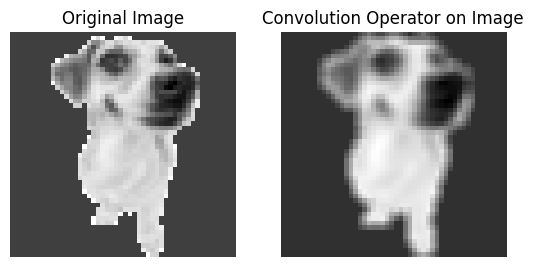

In [14]:
img = torch.tensor(plt.imread("img/dog.png"))[..., 0]

# kernel = torch.tensor([1.0, -2.0, 1.0])  # Laplacian
kernel = torch.tensor([1, 1, 1]) / 3  # Blur
M = image_operator_from_sep_kernels(img.shape, kernel, kernel)

convolution_output = M @ img.flatten()

# Visualize the original and shifted images
plt.subplot(121)
plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(122)
plt.imshow(convolution_output.reshape(img.shape), cmap="gray")
plt.title("Convolution Operator on Image")
plt.axis("off")
plt.show()

In [15]:
# Note that shifts and convolutions commute!
torch.allclose(S @ M, M @ S)

True

Note that both our 1D circulant matrices and 2D convolution operators are symmetric matrices!

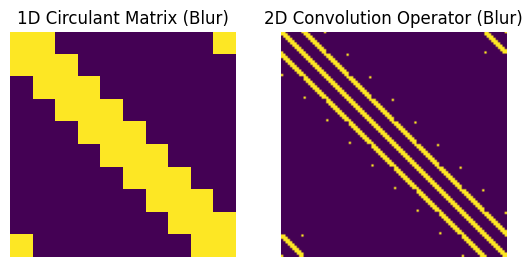

In [16]:
kernel = torch.tensor([1, 1, 1]) / 3  # Blur

circulant_check = matrix_from_convolution_kernel(kernel, 10)
M_check = image_operator_from_sep_kernels((10, 10), kernel, kernel)

plt.subplot(121)
plt.imshow(circulant_check)
plt.title("1D Circulant Matrix (Blur)")
plt.axis("off")

plt.subplot(122)
plt.imshow(M_check)
plt.title("2D Convolution Operator (Blur)")
plt.axis("off")
plt.show()

### Part 2.3: Spectral Analysis

Recall that many important operators in signal and image processing (such as convolution and blurring) can be understood by studying their eigenvalues and eigenvectors. In particular, the eigenvectors describe the “modes” of the system, while the eigenvalues indicate how strongly each mode is amplified or attenuated.

Implement eigendecomposition, which computes the eigenvalues and eigenvectors of a given self-adjoint linear operator.

In [17]:
def eigendecomposition(
    operator: Float[Tensor, "N N"], descending: bool = True
) -> Tuple[Float[Tensor, "N"], Float[Tensor, "N N"]]:
    """
    Computes the eigenvalues and eigenvectors of a self-adjoint (Hermitian) linear operator.

    Args:
        operator: Tensor of shape (N, N)
            A self-adjoint linear operator.
        descending: bool
            If True, sort the eigenvalues and eigenvectors in descending order.

    Returns:
        A tuple (eigenvalues, eigenvectors) where:
            eigenvalues: Tensor of shape (N,)
            eigenvectors: Tensor of shape (N, N)
    """
    # STUDENT CODE HERE
    eigenvalues, eigenvectors = torch.linalg.eigh(operator)
    if descending:
        idx = torch.argsort(eigenvalues, descending=True)
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
    # END STUDENT CODE
    return eigenvalues, eigenvectors



By inspecting the eigendecomposition of the convolution operator, we can recreate the figures from the Lecture!

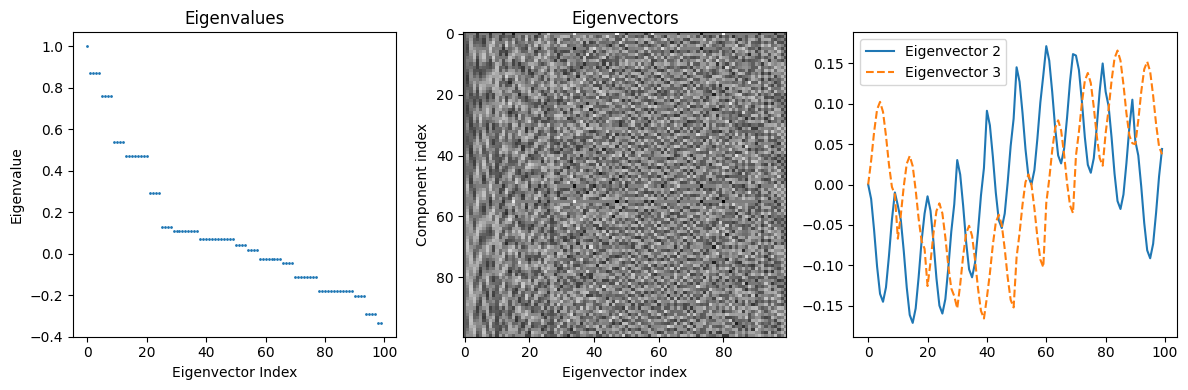

In [18]:
# DECOMPOSITION CHECK
# Note the kernel is smaller so that we can see the eigenvectors better
M = image_operator_from_sep_kernels((10, 10), kernel, kernel)
D, Q = eigendecomposition(M, descending=True)

plt.figure(figsize=(12, 4))

# Plot the eigenvalues using a scatter plot
plt.subplot(131)
plt.plot(D, "o", markersize=1)
plt.title("Eigenvalues")
plt.xlabel("Eigenvector Index")
plt.ylabel("Eigenvalue")

# Plot all the eigenvectors
plt.subplot(132)
im = plt.imshow(Q, aspect="auto", cmap="gray")
plt.title("Eigenvectors")
plt.xlabel("Eigenvector index")
plt.ylabel("Component index")

# Plot a few of the eigenvectors
plt.subplot(133)
plt.plot(D[1] * Q[:, 1], label="Eigenvector 2")
plt.plot(D[2] * Q[:, 2], linestyle="--", label="Eigenvector 3")
plt.legend()

plt.tight_layout()
plt.show()

### Part 2.4: The Fourier Transform!

With the eigendecomposition of our operator, we can change the basis of any flattened image or linear operator to be expressed in terms of the eigenvectors of our operator. For our 2D convolution, this is precisely the 2D Fourier transform!

Implement fourier_transform, which projects a flattened image to an eigenbasis.

In [19]:
def fourier_transform(
    img: Float[Tensor, "N"], basis: Float[Tensor, "N N"]
) -> Float[Tensor, "N"]:
    """
    Projects a flattened image onto the Fourier (eigen) basis.

    Args:
        img: Tensor of shape (N,)
            A flattened image.
        basis: Tensor of shape (N, N)
            The Fourier eigenbasis.

    Returns:
        Tensor of shape (N,)
            The image represented in the Fourier domain.
    """
    # STUDENT CODE HERE
    img_fourier = basis.T @ img
    # END STUDENT CODE
    return img_fourier


Implement fourier_transform_operator, which applies a change of basis defined by an eigenbasis to a given linear operator.

In [20]:
def fourier_transform_operator(
    operator: Float[Tensor, "N N"], basis: Float[Tensor, "N N"]
) -> Float[Tensor, "N N"]:
    """
    Computes the representation of a linear operator in the Fourier (eigen) basis.

    Args:
        operator: Tensor of shape (N, N)
            The original linear operator in pixel space.
        basis: Tensor of shape (N, N)
            The Fourier eigenbasis.

    Returns:
        Tensor of shape (N, N)
            The operator represented in the Fourier basis.
    """
    # STUDENT CODE HERE
    operator = basis.T @ operator @ basis
    # END STUDENT CODE
    return operator


Implement inv_fourier_transform, which returns a flattened image projected onto an eigenbasis back to pixel space.

In [21]:
def inv_fourier_transform(
    fourier_img: Float[Tensor, "N"], basis: Float[Tensor, "N N"]
) -> Float[Tensor, "N"]:
    """
    Reconstructs an image in pixel space from its Fourier coefficients using the provided eigenbasis.

    Args:
        fourier_img: Tensor of shape (N,)
            The image in the Fourier domain.
        basis: Tensor of shape (N, N)
            The Fourier eigenbasis used in the forward transform.

    Returns:
        Tensor of shape (N,)
            The reconstructed image in pixel space.
    """
    # STUDENT CODE HERE
    img_reconstructed = basis @ fourier_img
    # END STUDENT CODE
    return img_reconstructed


Run the cell below to notice how the function fourier_transform_operator creates operators that are (block)-diagonalized. 

This is because convolution in the spatial domain corresponds to element-wise multiplication in the frequency domain. Each block corresponds to a specific frequency range, and the operator acts independently on each frequency component. This structure is highly desirable because it makes computations much more efficient (similar to how FFT makes convolution faster), as operations on diagonal matrices have O(n) complexity! Additionally, this block-diagonal structure makes it easier to analyze the effect of the operator on different frequency components, which is useful for designing filters and understanding their behaviors.

In [22]:
# For the convolution operator (here, M) we expect a diagonal matrix
M = image_operator_from_sep_kernels(img.shape, kernel, kernel)
_, Q = eigendecomposition(M)

M_fourier = fourier_transform_operator(M, Q)
diag_error = torch.norm(M_fourier - torch.diag(torch.diag(M_fourier)))
print("Off-diagonal norm for convolution operator:", diag_error)

Off-diagonal norm for convolution operator: tensor(4.5941e-05)


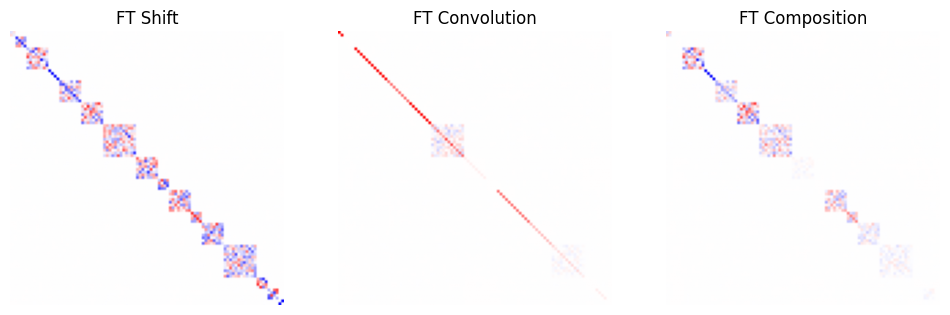

In [23]:
# For the shift operator:
S_fourier = fourier_transform_operator(S, Q)

# For another convolution:
kernel = torch.tensor([1.0, -2.0, 1.0])  # Laplacian
# kernel = torch.tensor([1, 1, 1]) / 3 # Blur
M1 = image_operator_from_sep_kernels(img.shape, kernel, kernel)
M1_fourier = fourier_transform_operator(M1, Q)

# For their composition:
M2 = S @ M1
M2_fourier = fourier_transform_operator(M2, Q)

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(S_fourier[-100:, -100:], cmap="bwr", vmin=-1, vmax=1)
plt.title("FT Shift")
plt.axis("off")

plt.subplot(132)
plt.imshow(M1_fourier[-100:, -100:], cmap="bwr", vmin=-1, vmax=1)
plt.title("FT Convolution")
plt.axis("off")

plt.subplot(133)
plt.imshow(M2_fourier[-100:, -100:], cmap="bwr", vmin=-1, vmax=1)
plt.title("FT Composition")
plt.axis("off")

plt.show()

Further, notice how the bright regions in the Fourier-domain image are concentrated in a small set of frequency components. 

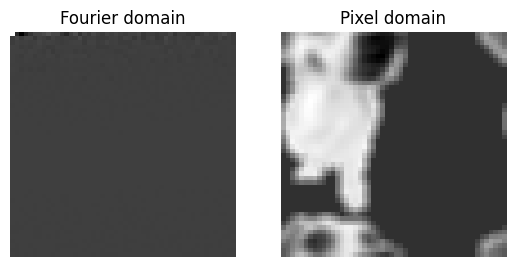

In [24]:
fourier_img = fourier_transform(img.flatten(), Q)
fourier_img = M_fourier @ S_fourier @ fourier_img  # Feel free to experiment here!
pixel_img = inv_fourier_transform(fourier_img, Q)

plt.subplot(121)
plt.imshow(fourier_img.reshape(img.shape), cmap="gray")
plt.title("Fourier domain")
plt.axis("off")

plt.subplot(122)
plt.imshow(pixel_img.reshape(img.shape), cmap="gray")
plt.title("Pixel domain")
plt.axis("off")
plt.show()

## Part 3: Gaussian Filters
>In this section, we will discuss the best way to compute [image derivatives](https://en.wikipedia.org/wiki/Image_derivative).

To compute image derivatives, you may have previously seen various finite-differences approximations of the gradient (e.g., [Sobel filter](https://en.wikipedia.org/wiki/Sobel_operator)). However, [these filters have numerous problems](https://www.crisluengo.net/archives/22/). Chief amongst these issues is the preservation of high frequency noise, which makes the gradients output of these filters a very poor approximation of the image derivative. Here, you will derive and implement Gaussian filters, a highly accurate, exact (up to a smoothing), and efficient way to compute image derivatives.

To motivate Gaussian filters, let $I(x,y)$ be a 2D image and let $G(x,y)$ be a 2D Gaussian with mean $\mu = 0$ and isotropic variance $\sigma^2$. From the properties of convolution, we have:

$$
\frac{d}{dx}(I * G)
= \frac{dI}{dx} * G
= \frac{dG}{dx} * I
= G^{(1)} * I.
$$

That is, the convolution of the gradient of our image with a Gaussian is equivalent to the convolution of the derivative of a Gaussian with our image!

Why is this exciting? Because we can now compute the exact derivative of a blurred version of our image (Gaussian derivatives have closed-form formulas), instead of relying on finite differences. This also let's us easily calculate higher-order image derivatives with $G^{(n)} \times I.$

It's worth noting that you also have to smooth an image prior to applying a Sobel filter anyways (because they amplify high-frequency noise), so you really gain nothing by avoiding Gaussian filters!





### Part 3.1: Implementing a 1D Gaussian filter

In this part, you will implement a 1D Gaussian filter with $n$-th order derivatives in `_gaussian_kernel_1d`.

Derivatives of Gaussian functions have nice closed-form formulas. However, since we sample finite-length Gaussian kernels for convolution, some numerical errors will creep in if we simply use the chain rule to obtain higher-order Gaussian filters.

---

#### Polynomial Response Conditions

1. Derive the response of $G^{(n)}$ to $f(x) = 1$ for $n \ge 1$.

   $$
   G^{(n)} * 1
   $$

   What does this tell you the **mean** of your Gaussian derivative kernel should be?

2. Derive the response of $G^{(n)}$ to $f(x) = x^n$ for $n \ge 1$.

   $$
   G^{(n)} * x^n
   $$

   What does this tell you about the **sum of your kernel when multiplied by $x^n$**?

#### Implementation Details

- Feel free to hard-code the second-order derivatives or derive and use a closed-form expression for the $n$-th derivative of a Gaussian (see: [hermite polynomials](https://en.wikipedia.org/wiki/Hermite_polynomials)).
- Let the radius of the filter be $r = \lceil \sigma t \rceil, $ where $t$ is the truncation hyperparameter. Note that the total length of the filter should therefore be $2r + 1.$
- You must use the polynomial response conditions to guide your answer.

In [25]:
def _gaussian_filter_1d(
    sigma: float,  # Standard deviation of the Gaussian
    order: int,  # Order of the derivative
    truncate: float = 4.0,  # Truncate the filter at this many standard deviations
    dtype: torch.dtype = torch.float32,  # Data type to run the computation in
    device: torch.device = torch.device("cpu"),  # Device to run the computation on
) -> Float[Tensor, " filter_size"]:
    
    def hermite(x, n):
        # STUDENT CODE HERE
        if n == 0:
            return torch.ones_like(x)
        if n == 1:
            return x / sigma

        h_nm2 = torch.ones_like(x)
        h_nm1 = x
        for k in range(2, n + 1):
            h_n = x * h_nm1 - (k - 1) * h_nm2
            h_nm2, h_nm1 = h_nm1, h_n
        return h_nm1 / (sigma**n)
        # END STUDENT CODE
    
    # STUDENT CODE HERE
    radius = int(truncate * sigma + 0.5)
    # END STUDENT CODE

    positions = torch.arange(-radius, radius + 1, device=device, dtype=dtype)
    u = positions / sigma
    k = math.sqrt(1 / (2 * torch.pi * sigma**2))
    kernel = k * (-(u**2) / 2).exp()

    if order == 0:
        kernel /= kernel.sum()
        return kernel

    # Compute the derivative of the Gaussian kernel
    kernel *= (-1) ** order * hermite(u, order)

    # STUDENT CODE HERE
    kernel -= kernel.mean()
    target = -math.factorial(order) if order % 2 == 1 else math.factorial(order)
    kernel *= target / (kernel * positions.pow(order)).sum()
    # END STUDENT CODE

    return kernel


### Part 3.2: Implementing a 2D Gaussian filter

Use the separability of the 2D Gaussian filter to implement the following **derivatives**.

Note: A 2D Gaussian can be written as the product of two 1D Gaussians: $ G(x,y) = G(x)\,G(y). $

In [26]:
def zeroth_order(img: Float[Tensor, "*H W"], sigma: float) -> Float[Tensor, "*H W"]:
    # STUDENT CODE HERE
    img_modified = gaussian_filter(img, sigma=sigma, order=[0, 0])
    # END STUDENT CODE
    return img_modified

def first_order_x(img: Float[Tensor, "*H W"], sigma: float) -> Float[Tensor, "*H W"]:
    # STUDENT CODE HERE
    img_dx = gaussian_filter(img, sigma=sigma, order=[0, 1])
    # END STUDENT CODE
    return img_dx


def first_order_y(img: Float[Tensor, "*H W"], sigma: float) -> Float[Tensor, "*H W"]:
    # STUDENT CODE HERE
    img_dy = gaussian_filter(img, sigma=sigma, order=[1, 0])
    # END STUDENT CODE
    return img_dy


def first_order_xy(img: Float[Tensor, "*H W"], sigma: float) -> Float[Tensor, "*H W"]:
    # STUDENT CODE HERE
    img_dxy = gaussian_filter(img, sigma=sigma, order=[1, 1])
    # END STUDENT CODE
    return img_dxy

def second_order_xx(img: Float[Tensor, "*H W"], sigma: float) -> Float[Tensor, "*H W"]:
    # STUDENT CODE HERE
    img_dxx = gaussian_filter(img, sigma=sigma, order=[0, 2])
    # END STUDENT CODE
    return img_dxx

def second_order_yy(img: Float[Tensor, "*H W"], sigma: float) -> Float[Tensor, "*H W"]:
    # STUDENT CODE HERE
    img_dyy = gaussian_filter(img, sigma=sigma, order=[2, 0])
    # END STUDENT CODE
    return img_dyy


Implementing a numerically stable second-order Gaussian filter can be complicated. Compare your implementation, which should return a constant zero-valued second-derivative in the y-direction, with a package that implements Gaussian filters incorrectly... `scipy`!

`scipy`'s implementation has errors of magnitude $10^3$, while yours should be < $10^{-13}$.

Why does this occur? This discrepancy occurs because computing higher-order derivatives of Gaussian filters is numerically sensitive, especially when the filter is truncated to a finite length. In theory, the second derivative of a linear function is exactly zero. Since the test image is constructed so that its second derivative in the $y$-direction is zero, an ideal Gaussian second-derivative filter should produce values very close to zero everywhere. However, in practice, Gaussian filters must be sampled and truncated. If derivatives are computed by repeatedly applying finite-difference or discrete differentiation rules, small approximation errors are introduced. These errors accumulate and are amplified when taking higher-order derivatives, leading to large numerical inaccuracies.

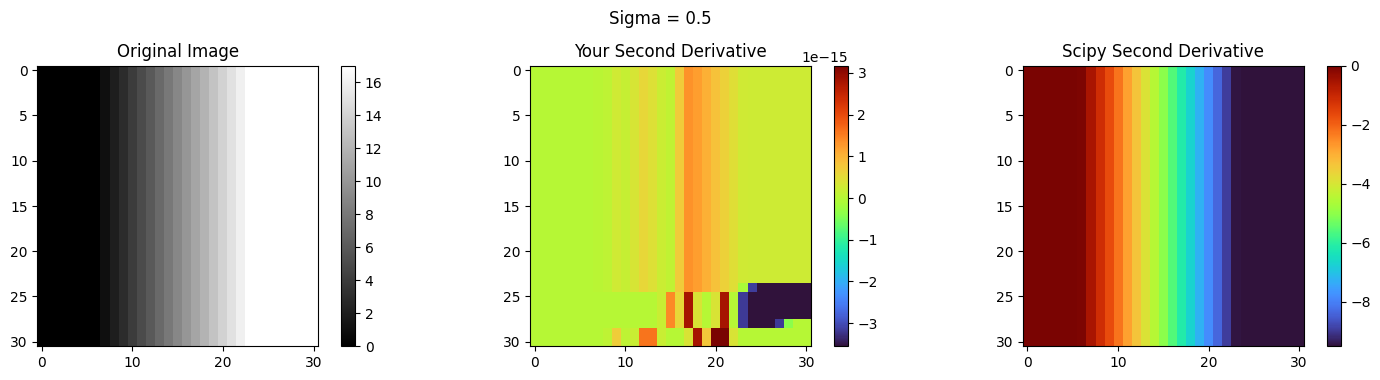

In [27]:
# Construct an image with a zero-valued second-derivative in the column-direction
img = torch.zeros(1, 1, 31, 31, dtype=torch.float64)
img[..., 7:24] += torch.arange(1, 18)
img[..., 24:] += 17

for sigma in [0.5]: # Modify as desired
    # Apply your second-derivative filter
    our_second_derivative = second_order_yy(img, sigma=sigma)

    # Apply the second-derivative filter using scipy
    scipy_second_derivative = gaussian_filter_scipy(
        img.numpy().squeeze(), sigma=sigma, order=[2, 0]
    )

    # Plot the original image and the filtered images
    plt.figure(figsize=(15, 3.75))
    plt.subplot(131)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title("Original Image")
    plt.colorbar()

    plt.subplot(132)
    plt.imshow(our_second_derivative.squeeze(), cmap="turbo")
    plt.title("Your Second Derivative")
    plt.colorbar()

    plt.subplot(133)
    plt.imshow(scipy_second_derivative, cmap="turbo")
    plt.title("Scipy Second Derivative")
    plt.colorbar()

    plt.suptitle(f"Sigma = {sigma}")
    plt.tight_layout()
    plt.show()

/opt/homebrew/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/opt/homebrew/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/opt/homebrew/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs


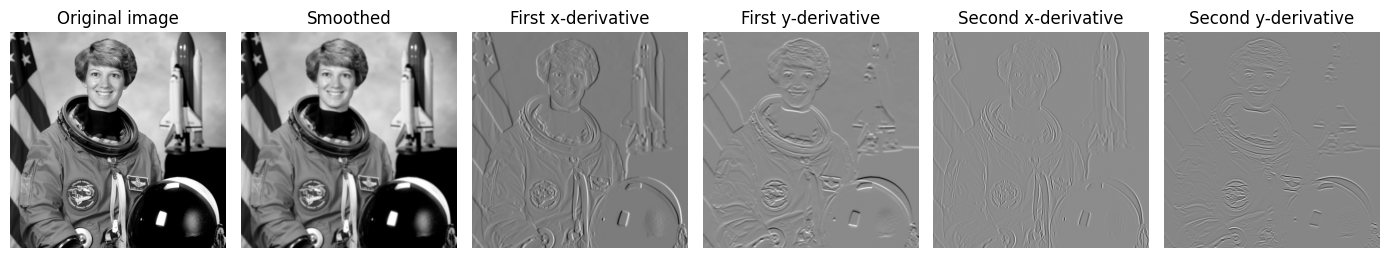

In [28]:
sigma = 1
fig, axs = imshow(
    img := astronaut(),
    zeroth_order(img, sigma),
    first_order_x(img, sigma),
    first_order_y(img, sigma),
    second_order_xx(img, sigma),
    second_order_yy(img, sigma),
)
axs[0].set_title("Original image")
axs[1].set_title("Smoothed")
axs[2].set_title("First x-derivative")
axs[3].set_title("First y-derivative")
axs[4].set_title("Second x-derivative")
axs[5].set_title("Second y-derivative")
plt.show()

### Part 3.3: Implementing the Laplacian of Gaussian (LoG)
The Laplacian operator is defined as

$$
\Delta = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}.
$$

When implemented using Gaussian filters, this operator is called the **Laplacian of Gaussian (LoG)**.

In [29]:
def log(img: Float[Tensor, "*H W"], sigma: float) -> Float[Tensor, "*H W"]:
    # STUDENT CODE HERE
    img_log = second_order_xx(img, sigma) + second_order_yy(img, sigma)
    # END STUDENT CODE
    return img_log


/opt/homebrew/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/opt/homebrew/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/opt/homebrew/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs


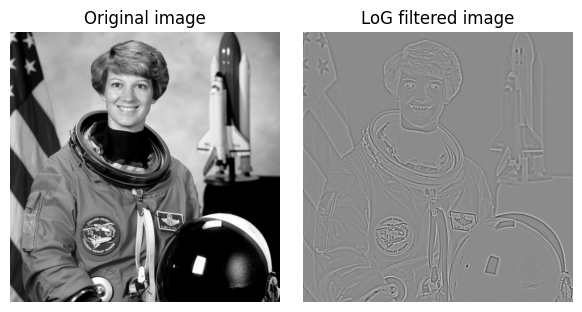

In [30]:
sigma = 1
fig, axs = imshow(
    img := astronaut(),
    log(img, sigma),
)
axs[0].set_title("Original image")
axs[1].set_title("LoG filtered image")
plt.show()

### Part 3.4: Steerable Filters
> In this part, we will discuss [steerable filters](https://people.csail.mit.edu/billf/publications/Design_and_Use_of_Steerable_Filters.pdf), a method of computing filter responses at any orientation.

A steerable first-order Gaussian filter can be oriented at any angle using the formula

$$
G_\theta^{(1)}
=
G_{0^\circ}^{(1)} \cos\theta
+
G_{90^\circ}^{(1)} \sin\theta.
$$

First, start by implementing a steerable first-order Gaussian filter.

In [31]:
def oriented_filter(theta: float, sigma: float, **kwargs) -> Float[Tensor, "N N"]:
    """
    Return an oriented first-order Gaussian filter
    given an angle (in radians) and standard deviation.

    Hint:
    - Use `.gauss._gaussian_filter_1d`!

    Implementation details:
    - **kwargs are passed to `_gaussian_filter_1d`
    """
    theta = torch.tensor(theta)
    # STUDENT CODE HERE
    smooth = _gaussian_filter_1d(sigma=sigma, order=0, **kwargs)
    grad = _gaussian_filter_1d(sigma=sigma, order=1, **kwargs)

    gx = torch.outer(smooth, grad)
    gy = torch.outer(grad, smooth)

    theta = theta.to(dtype=smooth.dtype, device=smooth.device)
    filter_2d = gx * torch.cos(theta) + gy * torch.sin(theta)
    # END STUDENT CODE
    return filter_2d


A 2D function to convolve an image with a steerable filter:

In [32]:
def conv(
    img: Float[Tensor, "B 1 H W"],  # Input image
    kernel: Float[Tensor, "N N"] | Complex[Tensor, "N N"],  # Convolutional kernel
    mode: str = "reflect",  # Padding mode
) -> Float[Tensor, "B 1 H W"]:
    """
    Convolve an image with a 2D kernel (assume N < H and N < W).
    """
    # STUDENT CODE HERE
    N = kernel.shape[-1]
    pad = N // 2
    img_padded = F.pad(img, (pad, pad, pad, pad), mode=mode)

    if torch.is_complex(kernel):
        weight_real = kernel.real.to(dtype=img.dtype, device=img.device).unsqueeze(0).unsqueeze(0)
        weight_imag = kernel.imag.to(dtype=img.dtype, device=img.device).unsqueeze(0).unsqueeze(0)
        out_real = F.conv2d(img_padded, weight_real)
        out_imag = F.conv2d(img_padded, weight_imag)
        img_convolved = torch.complex(out_real, out_imag)
    else:
        weight = kernel.to(dtype=img.dtype, device=img.device).unsqueeze(0).unsqueeze(0)
        img_convolved = F.conv2d(img_padded, weight)
    # END STUDENT CODE
    return img_convolved


A function to filter an image with a oriented filter:

In [33]:
def steer_the_filter(
    img: Float[Tensor, "B 1 H W"], theta: float, sigma: float, **kwargs
) -> Float[Tensor, "B 1 H W"]:
    """
    Return the image convolved with a steered filter.
    """
    theta = torch.tensor(theta)
    # STUDENT CODE HERE
    params = dict(kwargs)
    params.setdefault("dtype", img.dtype)
    params.setdefault("device", img.device)

    kernel = oriented_filter(theta, sigma, **params)
    img_steered = conv(img, kernel)
    # END STUDENT CODE
    return img_steered


And finally, instead of steering the function basis, start by constructing a filtered image basis and steer these images instead!


In [34]:
def steer_the_images(
    img: Float[Tensor, "B 1 H W"], theta: float, sigma: float, **kwargs
) -> Float[Tensor, "B 1 H W"]:
    """
    Return the steered image convolved with a filter.
    """
    theta = torch.tensor(theta)
    # STUDENT CODE HERE
    params = dict(kwargs)
    params.setdefault("dtype", img.dtype)
    params.setdefault("device", img.device)

    smooth = _gaussian_filter_1d(sigma=sigma, order=0, **params)
    grad = _gaussian_filter_1d(sigma=sigma, order=1, **params)

    img_x = conv(img, torch.outer(smooth, grad))
    img_y = conv(img, torch.outer(grad, smooth))

    theta = theta.to(dtype=img.dtype, device=img.device)
    img_steered = img_x * torch.cos(theta) + img_y * torch.sin(theta)
    # END STUDENT CODE
    return img_steered


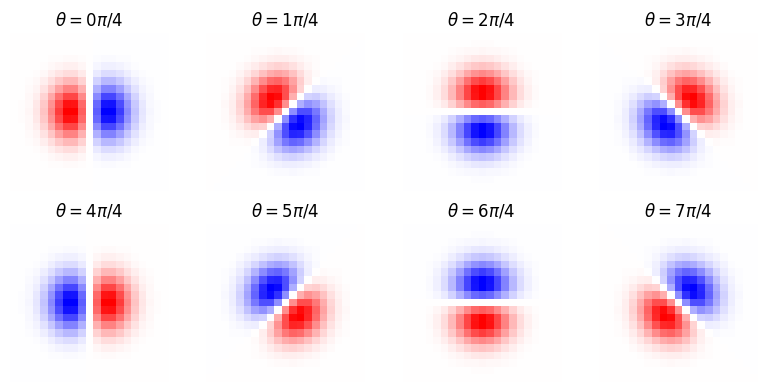

In [35]:
# Verify your 2D filters are properly oriented
fig, axs = plt.subplots(2, 4, figsize=(8, 4))
for idx, ax in enumerate(axs.flatten()):
    ax.imshow(oriented_filter(idx * torch.pi / 4, 2.5), cmap="bwr")
    ax.axis("off")
    ax.set_title(f"$\\theta = {idx} \\pi / 4$")
plt.tight_layout()
plt.show()

Run the cell below. What do you notice about the outputs of steer_the_filter and steer_the_images?
- What does this tell you the relationship between rotations in the image space and the space of oriented filters?
- Does this tell you anything interesting about the relationship between the Fourier Transform and rotations?


/opt/homebrew/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/opt/homebrew/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/opt/homebrew/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs
/var/folders/6z/j_9z9lks6fg4291gykskxkrm0000gr/T/ipykernel_15133/238115721.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta)
/opt/homebrew/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/opt/homebrew/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow

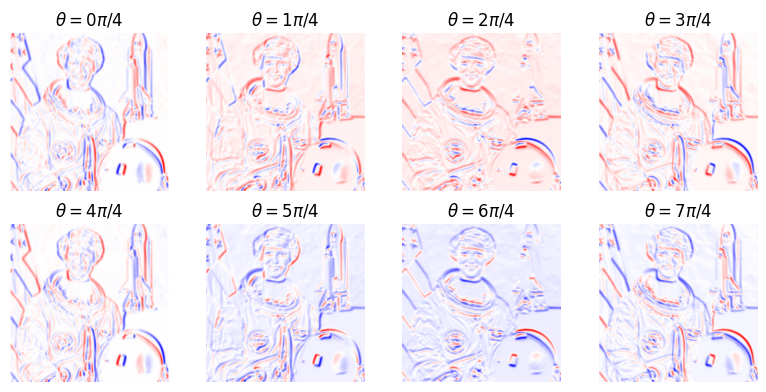

/opt/homebrew/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/opt/homebrew/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/opt/homebrew/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs
/opt/homebrew/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/opt/homebrew/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/opt/homebrew/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs
/opt/homebrew/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encounte

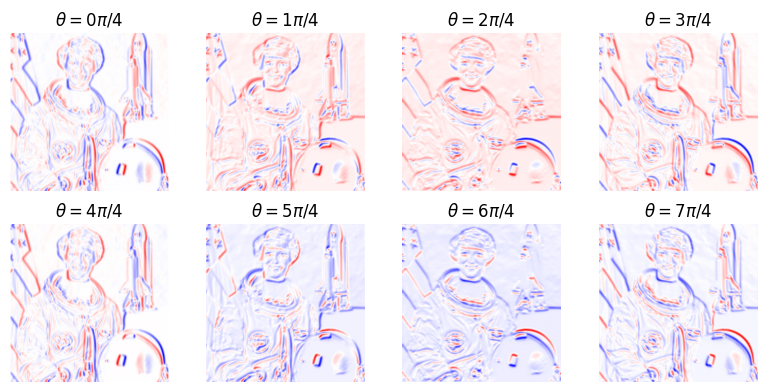

In [36]:
# Steer the filter
steered_filter = []
fig, axs = plt.subplots(2, 4, figsize=(8, 4))
for idx, ax in enumerate(axs.flatten()):
    theta = idx * torch.pi / 4
    img = steer_the_filter(astronaut(), theta=theta, sigma=2.5)
    ax.imshow(img.squeeze(), cmap="bwr")  # , vmin=-.125, vmax=.125)
    ax.axis("off")
    ax.set_title(f"$\\theta = {idx} \\pi / 4$")
    steered_filter.append(img)
plt.tight_layout()
plt.show()

# Steer the image
steered_images = []
fig, axs = plt.subplots(2, 4, figsize=(8, 4))
for idx, ax in enumerate(axs.flatten()):
    theta = idx * torch.pi / 4
    out = steer_the_images(astronaut(), theta=theta, sigma=2.5)
    ax.imshow(out.squeeze(), cmap="bwr")  # |, vmin=-.125, vmax=.125)
    ax.axis("off")
    ax.set_title(f"$\\theta = {idx} \\pi / 4$")
    steered_images.append(out)
plt.tight_layout()
plt.show()

We should notice the outputs of steer_the_filter and steer_the_images are identical! This is because convolution is linear and distributes over addition.

In steer_the_filter, we compute $I * \bigl(G_0 \cos\theta + G_{90} \sin\theta\bigr),$ while in 'steer_the_images', we compute $(I * G_0)\cos\theta + (I * G_{90})\sin\theta.$

By the distributive property of convolution, these expressions are mathematically equivalent, so both methods produce the same result. This equivalence shows that rotations in image space correspond directly to rotations in filter space. Rotating a filter and then applying it to an image is equivalent to steering the responses of fixed basis filters. Thus, oriented filters form a representation that is consistent under rotations. Finally, this property is analogous to the Fourier transform, where spatial shifts become simple phase changes in the frequency domain. Similarly, steerable filters convert rotations in the spatial domain into linear combinations of basis responses, making rotational structure easier to analyze and compute.


### Part 3.5: Measuring Edge Orientation in an Image

As a final application, we explore how to measure the orientation of edges in an image.

We do this using a complex-valued filter that encodes the image gradient in a single convolution. The filter is constructed as $G = G_x + i G_y$, where $G_x$ and $G_y$ are Gaussian-smoothed derivatives in the $x$ and $y$ directions. After convolving this filter with the image, we obtain $I_x + i I_y$, which represents the gradient field of the image.

The magnitude $|I_x + i I_y| = \sqrt{I_x^2 + I_y^2}$ measures the edge strength, while the phase $\arg(I_x + i I_y)$ gives the edge orientation.

Finally, multiplying the phase by the normalized magnitude suppresses unreliable orientations in flat regions, ensuring that only strong edges contribute meaningful direction estimates.

In [37]:
def measure_orientation(img, sigma: float, **kwargs):
    """
    Measure the local orientation of an image using a complex-valued filter. 

    Return a complex tensor where the magnitude encodes the strength of the orientation
    and the phase encodes the angle of the orientation.
    """
    def euler_filters(sigma: float, **kwargs):
        smooth   = _gaussian_filter_1d(sigma=sigma, order=0, **kwargs)
        grad     = _gaussian_filter_1d(sigma=sigma, order=1, **kwargs)
        real_kernel = torch.outer(smooth, grad)
        imag_kernel = torch.outer(grad, smooth)
        return real_kernel, imag_kernel

    def conv_real(img, kernel, mode="reflect"):
        N = kernel.shape[-1]
        pad = N // 2
        img_padded = F.pad(img, (pad, pad, pad, pad), mode=mode)
        weight = kernel.unsqueeze(0).unsqueeze(0)
        return F.conv2d(img_padded, weight)

    # STUDENT CODE HERE
    params = dict(kwargs)
    params.setdefault("dtype", img.dtype)
    params.setdefault("device", img.device)

    real_kernel, imag_kernel = euler_filters(sigma=sigma, **params)
    grad_x = conv_real(img, real_kernel)
    grad_y = conv_real(img, imag_kernel)

    orientation_measure = torch.angle(torch.complex(grad_x, grad_y))
    # END STUDENT CODE
    return orientation_measure


Confirm your image looks like the one in 3.5!

/opt/homebrew/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/opt/homebrew/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/opt/homebrew/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs


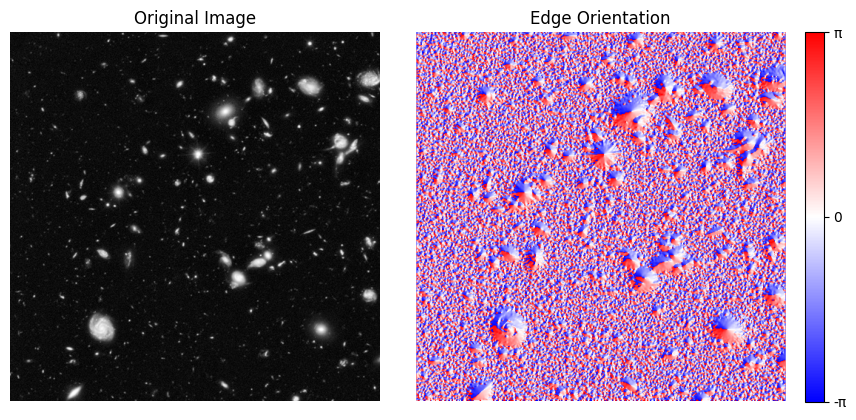

In [38]:
# Measure the orientation of edges in the image
img = hubble()
orientations = measure_orientation(img, sigma=1)

# Plot the original image and the orientation of edges
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8.5, 4), constrained_layout=True)
ax1.imshow(img.squeeze(), cmap="gray")
ax1.set_title("Original Image")
ax1.axis("off")

im = ax2.imshow(orientations.squeeze(), cmap="bwr", vmin=-torch.pi, vmax=torch.pi)
ax2.set_title("Edge Orientation")
ax2.axis("off")

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(
    im,
    cax=cax,
    ticks=[-torch.pi, 0, torch.pi],
    format=lambda x, _: "-π" if x < 0 else ("π" if x > 0 else "0"),
)

ax1.set_aspect("equal")
ax2.set_aspect("equal")

plt.savefig("img/hubble.png", bbox_inches="tight", pad_inches=0)
plt.show()

## Summary
Overall PSET2 connects signal processing, linear algebra, and image analysis to core ideas in computer vision. 

---

### Part 1: Steerable Bases

In this section, we learned how sine and cosine functions form a **steerable basis**.

- Showed that `a cos(x) + b sin(x)` is equivalent to a single shifted sine wave.
- Interpreted coefficients `(a, b)` as controlling amplitude and phase.
- Used the unit circle to steer signals by changing phase.
- Implemented functions to generate and visualize steered sinusoids.

Takeaway: Simple basis functions can be combined to control orientation and phase, which motivates steerable filters in vision.

---

### Part 2: Fourier Transform

This section explored how image operations can be represented.

- Built shift operators with circular boundaries.
- Represented convolution as circulant and block matrices.
- Verified that shifts and convolutions commute.
- Computed eigenvalues and eigenvectors of convolution operators.
- Implemented the Fourier transform as a change of basis.

Takeaway: The Fourier transform helps us understand and implement image filtering by separating images into independent frequency components.

---

### Part 3: Gaussian Filters

In the final section, we focused on computing image derivatives and orientations.

- Implemented Gaussian filters and their derivatives.
- Built stable first- and second-order derivative operators.
- Implemented the Laplacian of Gaussian (LoG).
- Constructed steerable filters for arbitrary orientations.
- Measured edge strength and direction using complex filters.

Takeaway: We saw how image filtering can be analyzed using eigen-decomposition, and how this naturally leads to Fourier representations.
